dataset = "dialogsum" | "samsum"

dataset_type = "train" | "test" | "validation"

In [145]:
from datasets import load_dataset
import json, pandas as pd, numpy as np 
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import matplotlib.pyplot as plt

In [175]:
dataset = "samsum"
dataset_type = "validation"
save_result_comets = True


FILTERED_COMET_FILE_PATH = f"./comet_{dataset_type}.json"
DIALOGSUM_FILE_PATH =  f"./dialogsum.{dataset_type}.jsonl"
FILE_OUTPUT_FOLDER = "."

In [147]:
summary_dict = None
dilaogsum = None
if dataset == "samsum":
    samsum = load_dataset('samsum')
    summary_dict = dict([(obj["id"], obj["summary"]) for obj in samsum[dataset_type]])
elif dataset == "dialogsum":
       dilaogsum = pd.read_json(path_or_buf=DIALOGSUM_FILE_PATH, lines=True)
       summary_dict = dict([(obj["fname"], obj["summary"]) for _, obj in dilaogsum[["fname","summary"]].iterrows()])
else:
    raise NotImplementedError()

In [148]:
comet = None
with open(FILTERED_COMET_FILE_PATH) as f:
    comet = json.loads(f.read())

In [149]:
cs_unraveled = []
for sample_id, sammple_cs in comet.items():
    for sentence_num, sentence_obj in enumerate(sammple_cs):
        for cs_key_or_sentence, cs_arr_or_sentence in sentence_obj.items():
            if type(cs_arr_or_sentence) == type([]):
                for cs in cs_arr_or_sentence:
                    cs_unraveled.append({"sample_id":sample_id,"sentence_id":sentence_num, \
                    "sentence":sentence_obj["sentence"], "cs_type":cs_key_or_sentence, "cs":cs, "summary":summary_dict[sample_id]})

In [150]:
len([obj["sentence"] for obj in cs_unraveled]) == sum([len(sentences) for _, sentences in comet.items()])*25

True

### Model details:
https://github.com/UKPLab/sentence-transformers

In [151]:
sbert = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [152]:
cs_unraveled[0]

{'sample_id': '13594102-1',
 'sentence_id': 0,
 'sentence': 'Good morning!',
 'cs_type': 'HinderedBy',
 'cs': " Steve doesn't want to be rude.",
 'summary': 'Steve is picking Anton up. Anton is running late.'}

In [154]:
cs_final= []
for cs_obj in tqdm(cs_unraveled):
    cs_emb =  sbert.encode(cs_obj["cs"])
    summary_emb = sbert.encode(cs_obj["summary"])
    sentence_emb = sbert.encode(cs_obj["sentence"])
    cs_final.append({**cs_obj,
                     "sentence_encoded":sentence_emb,"cs_encoded":cs_emb, "sumary_encoded":summary_emb,
                     "cos_similary_cs_summmary":float(util.cos_sim(cs_emb, summary_emb)),
                     "cos_similary_cs_sentence":float(util.cos_sim(cs_emb, sentence_emb))})

100%|██████████| 1000/1000 [00:46<00:00, 21.64it/s]


In [155]:
cs_dp = pd.DataFrame(cs_final)

In [156]:
cs_dp.iloc[:2,:]

,sample_id,sentence_id,sentence,cs_type,cs,summary,sentence_encoded,cs_encoded,sumary_encoded,cos_similary_cs_summmary,cos_similary_cs_sentence
0,13594102-1,0,Good morning!,HinderedBy,Steve doesn't want to be rude.,Steve is picking Anton up. Anton is running late.,"[-0.030852333, 0.028894726, 0.052327298, 0.028...","[0.015052282, 0.05038867, 0.032233246, -0.0616...","[-0.04964875, 0.09688901, -0.0061585177, 0.002...",0.371252,0.019528
1,13594102-1,0,Good morning!,HinderedBy,Steve doesn't have a phone.,Steve is picking Anton up. Anton is running late.,"[-0.030852333, 0.028894726, 0.052327298, 0.028...","[-0.06602965, 0.04579193, 0.07318786, -0.06163...","[-0.04964875, 0.09688901, -0.0061585177, 0.002...",0.375722,0.062230


In [157]:
peaks = [max(list(cs_dp["cos_similary_cs_summmary"])[25*(i-1):25*i]) for i in range(1,int(len(cs_dp)/25))]

In [158]:
best_cs_per_sentence_ours = cs_dp.loc[cs_dp.groupby(['sample_id','sentence_id'])['cos_similary_cs_summmary'].idxmax()]

In [159]:
best_cs_per_sentence_theirs = cs_dp.loc[cs_dp.groupby(['sample_id','sentence_id'])['cos_similary_cs_sentence'].idxmax()]

In [160]:
peaks_ours = best_cs_per_sentence_ours["cos_similary_cs_summmary"]
peaks_theirs = best_cs_per_sentence_theirs["cos_similary_cs_sentence"]

In [161]:
np.average(peaks_ours), np.std(peaks_ours)

(0.4475741066038609, 0.14524775820780916)

In [162]:
np.average(peaks_theirs), np.std(peaks_theirs)

(0.5123435266315937, 0.21041948166634905)

<Axes: >

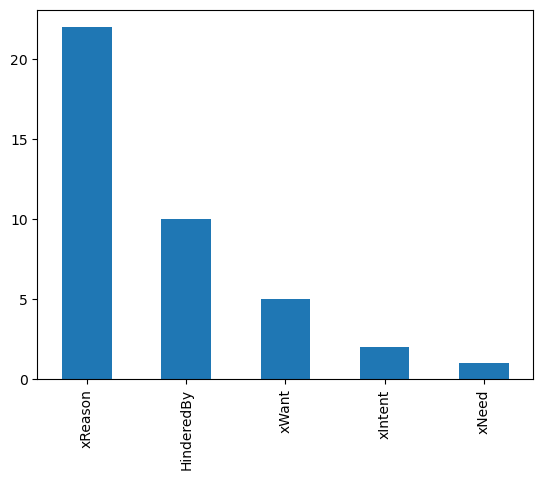

In [190]:
best_cs_per_sentence_ours['cs_type'].value_counts().plot.bar()

<Axes: >

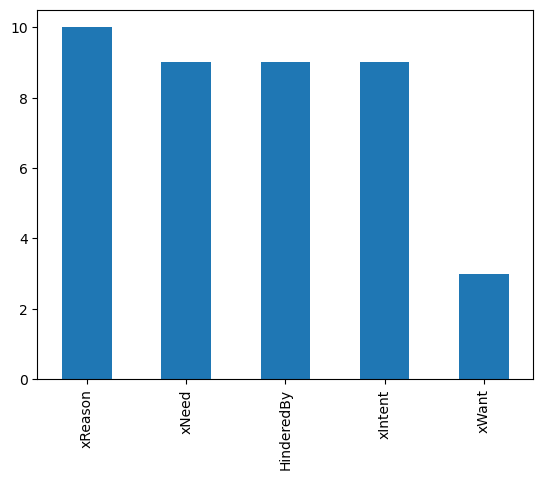

In [191]:
best_cs_per_sentence_theirs['cs_type'].value_counts().plot.bar()

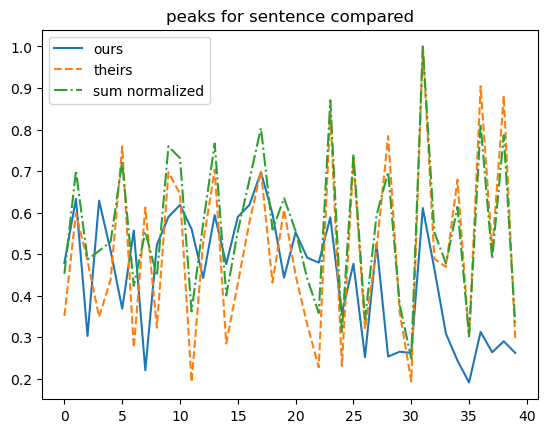

In [164]:

max_drow = 70
plt.plot(range(0,len(peaks_ours[:max_drow])),peaks_ours[:max_drow],  label ="ours")
plt.plot(range(0,len(peaks_theirs[:max_drow])), peaks_theirs[:max_drow],  label ="theirs", linestyle="--")
plt.plot(range(0,len(peaks_theirs[:max_drow])), np.array([n1+n2/2 for n1, n2 in zip(peaks_theirs[:max_drow], peaks_ours[:max_drow])])/max([n1+n2/2 for n1, n2 in zip(peaks_theirs[:max_drow], peaks_ours[:max_drow])]),  label ="sum normalized", linestyle="-.")
plt.title("peaks for sentence compared")
plt.legend() 
plt.show()

In [165]:
def convert_back_to_dict(df):
    converted_df = {}
    for _, row in df.iterrows():
        if converted_df.get(str(row["sample_id"])):
            converted_df[str(row["sample_id"])][str(row["sentence_id"])] = \
                {"sentence":row["sentence"], "relation":row["cs_type"], "out":row["cs"]}
        else:  converted_df[str(row["sample_id"])] = \
            {str(row["sentence_id"]): {"sentence":row["sentence"], "relation":row["cs_type"], "out":row["cs"]}}
    return converted_df

In [174]:
def save_files(converted_dfs_and_paths):
    for converted_df, path in converted_dfs_and_paths:
        with open(path, "w") as file:
            file.write(json.dumps(converted_df, indent=2))

In [176]:
if save_result_comets:
    converted_dfs_and_paths = [(convert_back_to_dict(best_cs_per_sentence_ours),\
                                f"{FILE_OUTPUT_FOLDER}/comet_{dataset}_{dataset_type}_z_ours.json"),\
                                (convert_back_to_dict(best_cs_per_sentence_theirs),\
                                f"{FILE_OUTPUT_FOLDER}/comet_{dataset}_{dataset_type}_z_theirs.json")]
    save_files(converted_dfs_and_paths)